In [1]:
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pytransform3d.rotations import matrix_from_quaternion
from pytransform3d.transformations import plot_transform

In [2]:
# Load data from the text file
file_path = "rtabmap_slam.txt"

# Read data, skipping the first header row
data = np.loadtxt(file_path, skiprows=1)

# Extract positions and orientations
timestamps = data[:, 0]
positions = data[:, 1:4]  # x, y, z
quaternions = data[:, 4:8]  # qx, qy, qz, qw

In [3]:
print(positions)
print(quaternions)

[[ 0.000000e+00  0.000000e+00  0.000000e+00]
 [ 6.009800e-02  4.942200e-02  6.972300e-02]
 [ 2.960410e-01 -1.064500e-01  8.432700e-02]
 [ 4.495790e-01 -1.242490e-01  7.427100e-02]
 [ 6.621150e-01 -6.810600e-02  8.277100e-02]
 [ 9.060940e-01 -1.802090e-01  8.160800e-02]
 [ 1.236158e+00 -3.206300e-01  9.089700e-02]
 [ 1.398994e+00 -3.070250e-01  7.713000e-02]
 [ 1.599402e+00 -4.321580e-01  8.371300e-02]
 [ 1.732875e+00 -4.884570e-01  7.868500e-02]
 [ 1.935818e+00 -4.385780e-01  9.166600e-02]
 [ 2.077891e+00 -4.417270e-01  6.715900e-02]
 [ 2.177533e+00 -4.379700e-01  7.030100e-02]
 [ 2.308773e+00 -2.455010e-01  5.703100e-02]
 [ 2.291804e+00 -2.026900e-02  8.779400e-02]
 [ 2.360167e+00  1.740660e-01  1.070610e-01]
 [ 2.449137e+00  2.957350e-01  1.026980e-01]
 [ 2.495442e+00  5.417480e-01  1.143720e-01]
 [ 2.518199e+00  6.642820e-01  8.299900e-02]
 [ 2.572847e+00  8.457100e-01  7.270800e-02]
 [ 2.587963e+00  9.174720e-01  7.633900e-02]
 [ 2.568080e+00  1.135523e+00  6.561100e-02]
 [ 2.56787

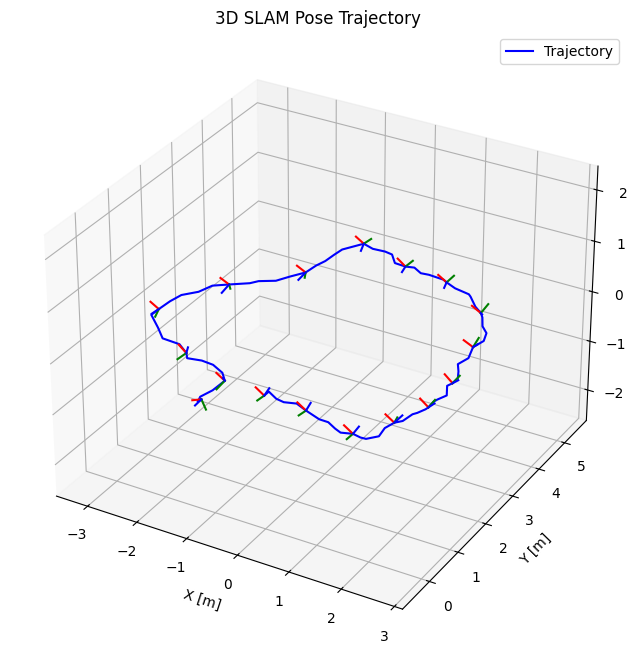

In [5]:
# Create 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot trajectory
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'b-', label="Trajectory")

# Plot coordinate frames at selected intervals
for i in range(0, len(positions), 5):  # Adjust step size for clarity
    position = positions[i]
    quaternion = quaternions[i]
    
    # Convert quaternion to rotation matrix
    rotation_matrix = matrix_from_quaternion(quaternion)
    
    # Create homogeneous transformation matrix
    transform = np.eye(4)
    transform[:3, :3] = rotation_matrix
    transform[:3, 3] = position  # Set translation

    # Plot frame
    plot_transform(ax=ax, A2B=transform, s=0.2)  # Scale of coordinate frame

# Labels and legend
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.axis('equal')
ax.set_title("3D SLAM Pose Trajectory")
ax.legend()
plt.show()

In [8]:
import numpy as np
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R

# Load data from the text file
file_path = "rtabmap_slam.txt"

# Read data, skipping the first header row
data = np.loadtxt(file_path, skiprows=1)

# Extract positions and quaternions
positions = data[:, 1:4]  # x, y, z
quaternions = data[:, 4:8]  # qx, qy, qz, qw

# Create a 3D scatter plot for the trajectory
fig = go.Figure(data=[go.Scatter3d(
    x=positions[:, 0],
    y=positions[:, 1],
    z=positions[:, 2],
    mode='lines',
    line=dict(color='blue', width=2),
    name='Trajectory',
    showlegend=False
)])

# Function to plot coordinate frames
def plot_coordinate_frame(fig, position, quaternion, scale=0.2):
    # Convert quaternion (qx, qy, qz, qw) to rotation matrix
    rotation = R.from_quat(quaternion).as_matrix()
    
    # Define origin
    origin = position
    
    # Define axes in local frame
    axes = np.eye(3) * scale
    
    # Transform axes to global frame
    transformed_axes = rotation @ axes
    
    # Define colors for x, y, z axes
    colors = ['red', 'green', 'blue']
    
    for i in range(3):
        fig.add_trace(go.Scatter3d(
            x=[origin[0], origin[0] + transformed_axes[0, i]],
            y=[origin[1], origin[1] + transformed_axes[1, i]],
            z=[origin[2], origin[2] + transformed_axes[2, i]],
            mode='lines',
            line=dict(color=colors[i], width=5),
            name=f'{colors[i]} axis',
            showlegend=False
        ))

# Plot coordinate frames at selected intervals
for i in range(0, len(positions), 5):  # Adjust step size for clarity
    plot_coordinate_frame(fig, positions[i], quaternions[i])

# Compute the range for each axis
x_range = positions[:, 0].max() - positions[:, 0].min()
y_range = positions[:, 1].max() - positions[:, 1].min()
z_range = positions[:, 2].max() - positions[:, 2].min()

# Determine the maximum range
max_range = max(x_range, y_range, z_range)

# Set the aspect ratio based on the maximum range
aspect_ratio = dict(x=x_range / max_range, y=y_range / max_range, z=z_range / max_range)

# Update layout to set equal aspect ratio
fig.update_layout(
    scene=dict(
        aspectmode='manual',
        aspectratio=aspect_ratio,
        xaxis=dict(title='X [m]'),
        yaxis=dict(title='Y [m]'),
        zaxis=dict(title='Z [m]')
    ),
    title='3D SLAM Pose Trajectory with Orientation Frames',
    legend=dict(x=0, y=1)
)

# Show the plot
fig.show()

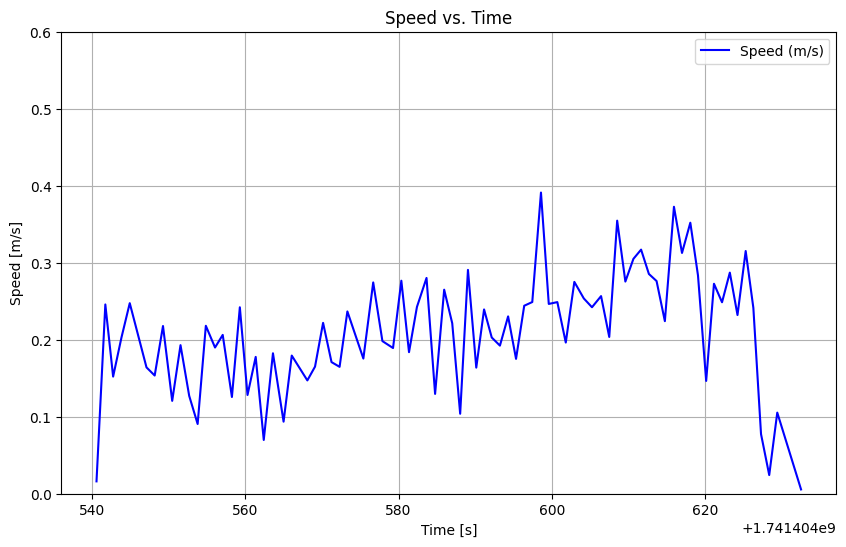

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from the text file
file_path = "rtabmap_slam.txt"

# Read data, skipping the first header row
data = np.loadtxt(file_path, skiprows=1)

# Extract timestamps and positions
timestamps = data[:, 0]
positions = data[:, 1:4]  # x, y, z

# Compute differences between consecutive timestamps and positions
delta_t = np.diff(timestamps)
delta_pos = np.diff(positions, axis=0)

# Calculate velocity components
velocities = delta_pos / delta_t[:, np.newaxis]

# Compute speed (norm of velocity)
speeds = np.linalg.norm(velocities, axis=1)

# Plot speed versus time
plt.figure(figsize=(10, 6))
plt.plot(timestamps[1:], speeds, label='Speed (m/s)', color='b')
plt.xlabel('Time [s]')
plt.ylabel('Speed [m/s]')
plt.title('Speed vs. Time')
plt.ylim(0, 0.6)  # Adjust limits for better visibility
# plt.axis('equal')
# plt.axis('tight')
plt.legend()
plt.grid(True)
plt.show()